In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = open('names.txt', 'r').read().splitlines()
words[:8]
# len(words) == 32033

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print("itos => ",itos)
print("stoi => ",stoi)

itos =>  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
stoi =>  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [54]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next character in the name
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# build the dataset
# Training / dev / test split of dataset === (80,10,10)

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next character in the name
    X, Y = [], []
    for w in words:
    # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))  # length of traing set
n2 = int(0.9*len(words))  # length of traning + dev set ==> length of dev set = n2 - n1

Xtr, Ytr = build_dataset(words[0:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [126]:
Xtr.shape, Xdev.shape, Xtest.shape, Ytr.shape, Ydev.shape, Ytest.shape

(torch.Size([182441, 3]),
 torch.Size([22902, 3]),
 torch.Size([22803, 3]),
 torch.Size([182441]),
 torch.Size([22902]),
 torch.Size([22803]))

In [191]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [192]:
for p in parameters:
    p.requires_grad = True

In [193]:
# lre  =  exponent for learning rate => 10^-3 to 1
# lrs  =  learning rates
lre = torch.linspace(-3, 0, 1000) # creates a tensor of 1000 numbers between 0.001 and 1 
lrs = 10**lre

In [194]:
lri = []     # learning rate on ith iteration
lossi = []   # loss while using the ith learning rate
stepi = []   # steps

In [ ]:
# Training of the model with oly training set
for i in range(200000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # ONe mini-batch has 32 examples
    
    # forward pass 
    embed = C[X[ix]] # shape == [32,3,2]
    h = embed.view(embed.shape[0], 30) @ w1 + b1 # h is hidden state
    a = torch.tanh(h)
    logits = a @ w2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])  # Calculates loss efficiently
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)


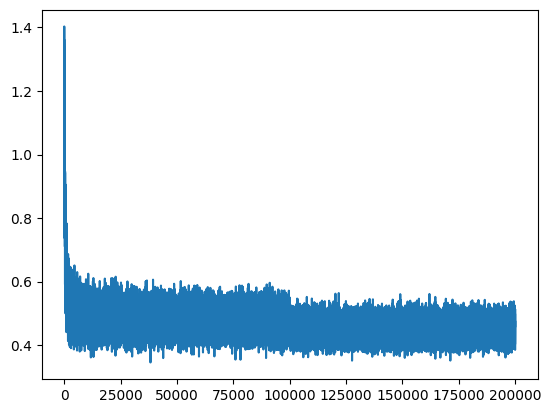

In [196]:
plt.plot(stepi, lossi)

In [197]:
embed = C[Xtr]
h = embed.view(embed.shape[0], 30) @ w1 + b1 # h is hidden state
a = torch.tanh(h)
logits = a @ w2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.8351, grad_fn=<NllLossBackward0>)

In [198]:
# Evaluating the loss using dev set
embed = C[Xdev]
h = embed.view(embed.shape[0], 30) @ w1 + b1 # h is hidden state
a = torch.tanh(h)
logits = a @ w2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8381, grad_fn=<NllLossBackward0>)

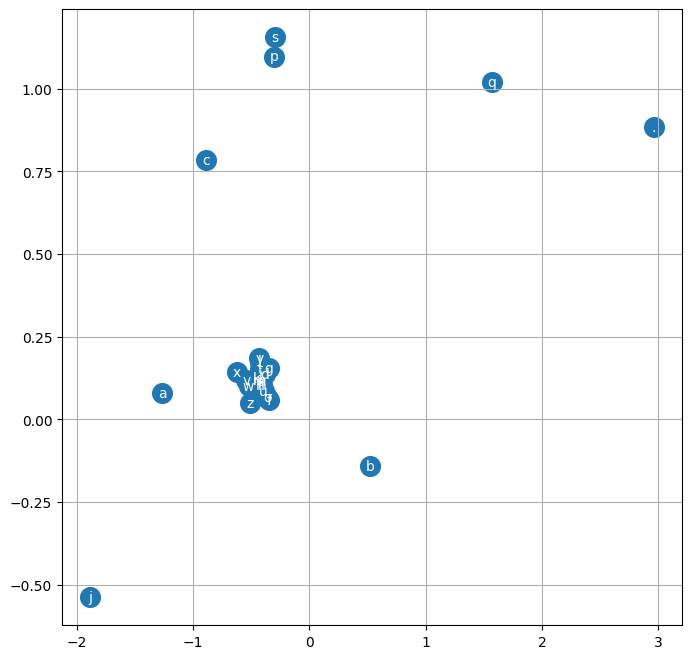

In [199]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s = 200)  # s == size of the datapoint
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va='center', color="white")
plt.grid('minor')

In [204]:
# Sample from the model

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

ernaaimyazhseelmnd.
ryal.
.
ethrsjradrlee.
adeeedieliihemy.
realeieiseananarneltzimhlkaa.
n.
sadbmrgshimies.
.
n.
ir.
ellklnnteuoanu.
aknedar.
yidlemehs.
laeja.
sknyaa.
hia.
aaaqtyuun.
zajrlveuren.
.
